## Customer Segmentation using Clustering

### Import Library

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
warnings.simplefilter("ignore")
import sys


### import data

In [2]:
def getinput():
    df=pd.read_csv("D:/data/clustering_data/marketing_campaign.csv", sep="\t")
    return df
df=getinput()

### Data information

In [3]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

### Check for null value

In [4]:
print(df.isnull().sum())

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


### Data cleaning

In [5]:
#Remove row with missing value
df=df.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 2216


In [6]:
#date
df["Dt_Customer"]=pd.to_datetime(df["Dt_Customer"])
dates=[]
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [7]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
df["Customer_For"] = days
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")
print(df["Customer_For"])

0       83894400000000000
1       10800000000000000
2       40780800000000000
3        5616000000000000
4       27734400000000000
              ...        
2235    46742400000000000
2236     5270400000000000
2237    27216000000000000
2238    27302400000000000
2239    67564800000000000
Name: Customer_For, Length: 2216, dtype: int64


In [8]:
#To get unique value from a categorial feature
print("Unique value in martial status",df["Marital_Status"].value_counts())
print("Unique value in education Status",df["Education"].value_counts())

Unique value in martial status Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
Unique value in education Status Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


### Feature Engineering

In [9]:
#Create a column age using Birth year of the customer
df["Age"]=2023-df["Year_Birth"]

#Total spending on various items
df["Spent"]=df["MntWines"]+df["MntFruits"]+df["MntMeatProducts"]+df["MntFishProducts"]+df["MntSweetProducts"]+df["MntGoldProds"]

#Deriving living situation by marital status
df["Living_with"]=df["Marital_Status"].replace({"Married":"Partner","Together":"Partner","Single":"Alone","Divorced":"Alone","Widow":"Alone","Alone":"Alone","YOLO":"Alone","Absurd":"Alone"})

#Total number of children living in the house
df["Children"]=df["Kidhome"]+df["Teenhome"]

#Total number of people in the house
df["Family_Size"]=df["Living_with"].replace({"Partner":2,"Alone":1})++ df["Children"]

#To find if parents are there in a hoouse hold
df["Is_Parent"]=np.where(df.Children>0,1,0)

##Segmenting education levels in three groups
df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
#df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
df = df.drop(to_drop, axis=1)
print(df)

         Education   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
0         Graduate  58138.0        0         0       58       635         88   
1         Graduate  46344.0        1         1       38        11          1   
2         Graduate  71613.0        0         0       26       426         49   
3         Graduate  26646.0        1         0       26        11          4   
4     Postgraduate  58293.0        1         0       94       173         43   
...            ...      ...      ...       ...      ...       ...        ...   
2235      Graduate  61223.0        0         1       46       709         43   
2236  Postgraduate  64014.0        2         1       56       406          0   
2237      Graduate  56981.0        0         0       91       908         48   
2238  Postgraduate  69245.0        0         1        8       428         30   
2239  Postgraduate  52869.0        1         1       40        84          3   

      MntMeatProducts  MntFishProducts 

### To plot some selected feature

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

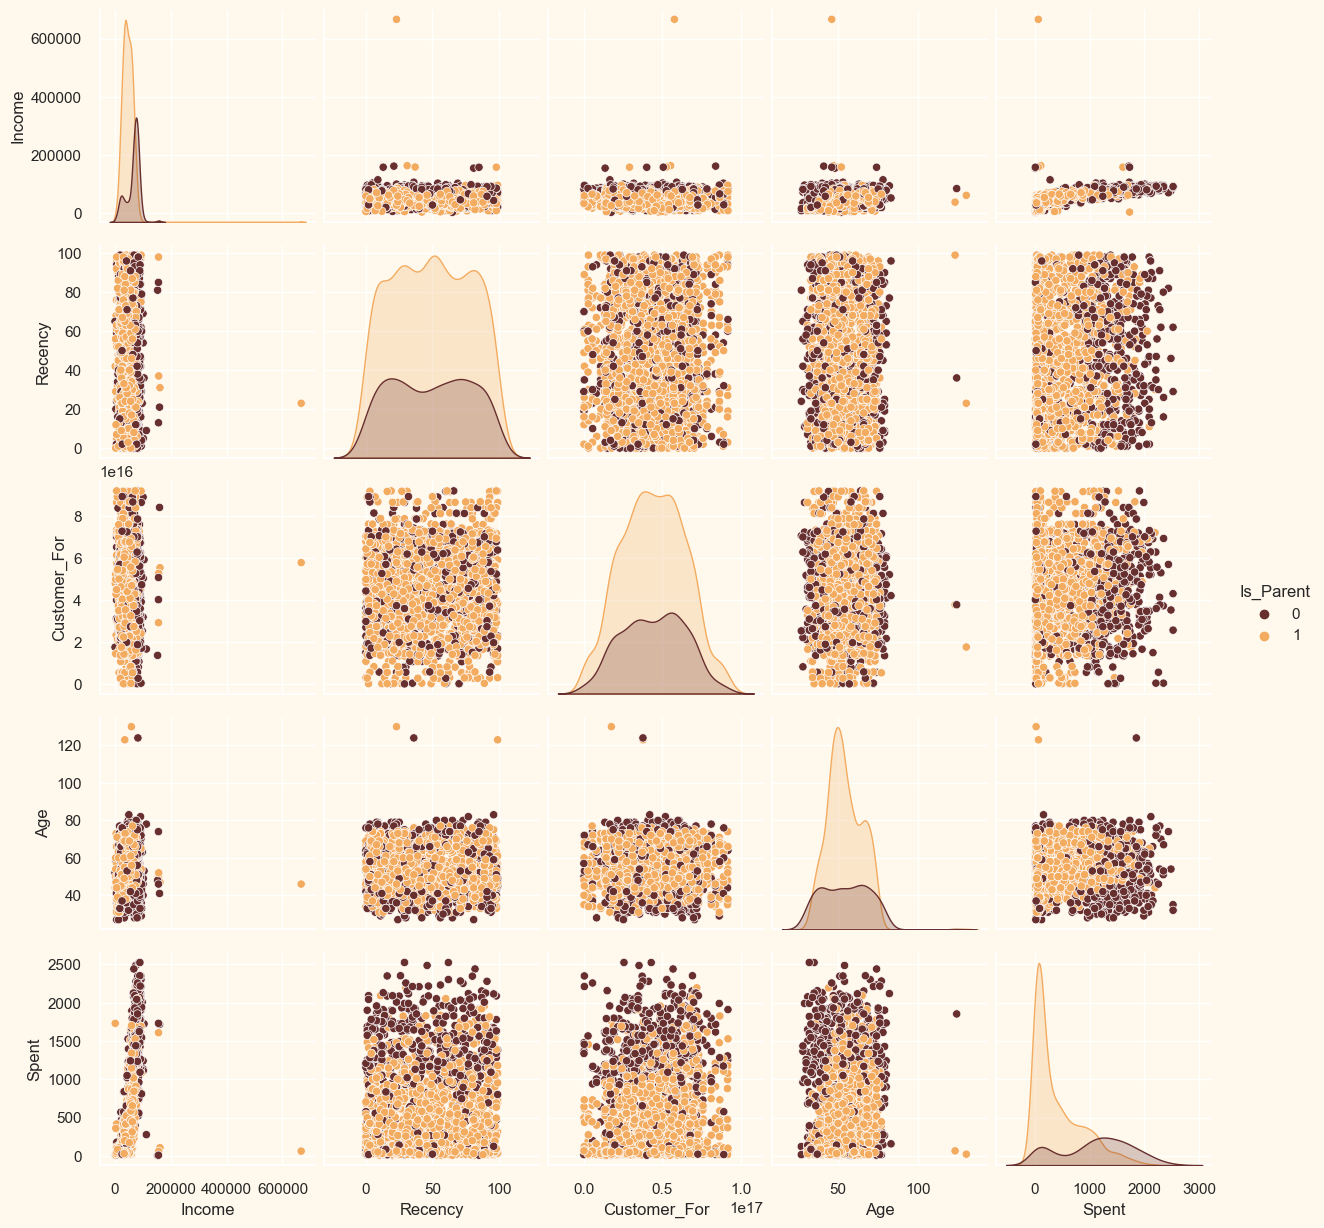

In [10]:
#To plot some selected features 
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(df[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()

### Droping the outiler using cap on income and age

In [11]:
df=df[df["Age"]<90]
df=df[df["Income"]<600000]
print("The total number of data-points after removing the outliers are:", len(df))

The total number of data-points after removing the outliers are: 2212


<Axes: >

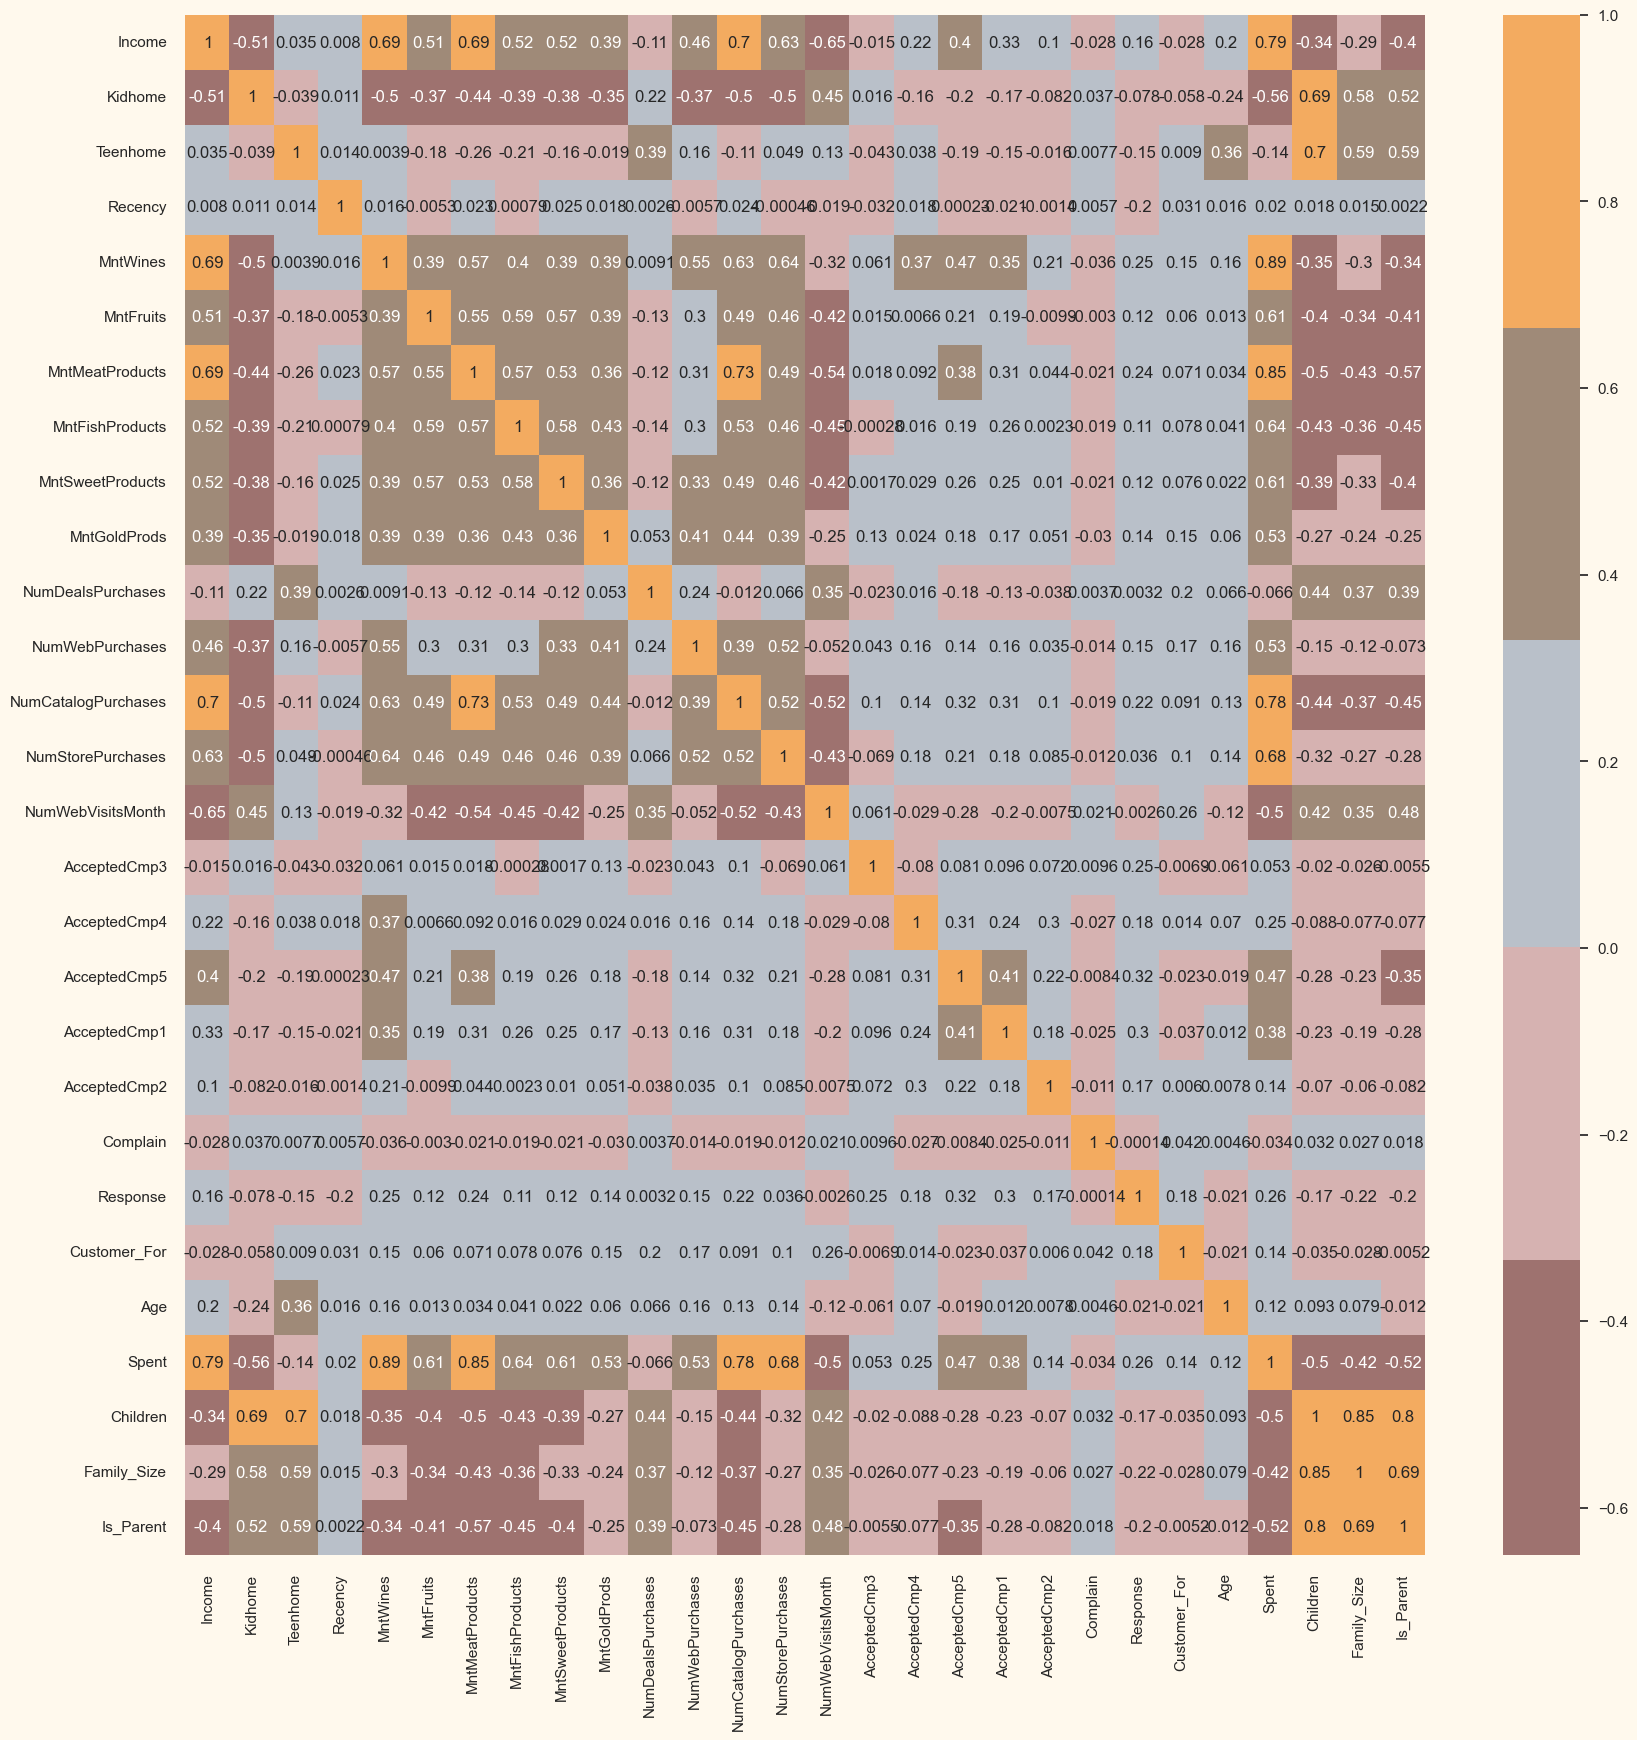

In [12]:
#correlation matrix
corrmat= df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

### Data Preprocessing

In [13]:
#Get list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_with']


In [14]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
print("All features are now numerical")

All features are now numerical


In [15]:
#Creating a copy of data
ds = df.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [16]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_with,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


### Dimensionality Reduction Technique

In [17]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-1.413376e-16,2.878377,-5.969399,-2.538493,-0.780421,2.383290,7.444305
col2,2212.0,-3.212219e-17,1.706839,-4.312130,-1.328310,-0.158015,1.242275,6.142661
col3,2212.0,6.825964e-17,1.221943,-3.525467,-0.824059,-0.022617,0.805138,6.589755


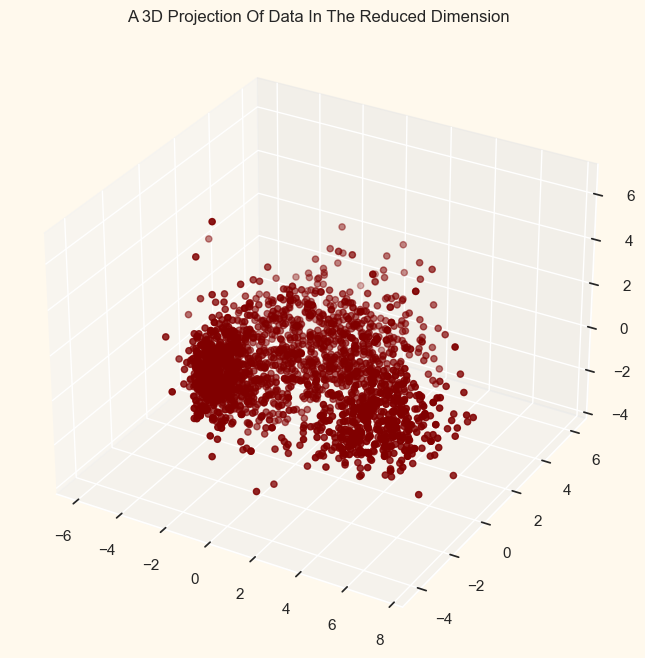

In [18]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

### Clustering 

Elbow Method to determine the number of clusters to be formed:


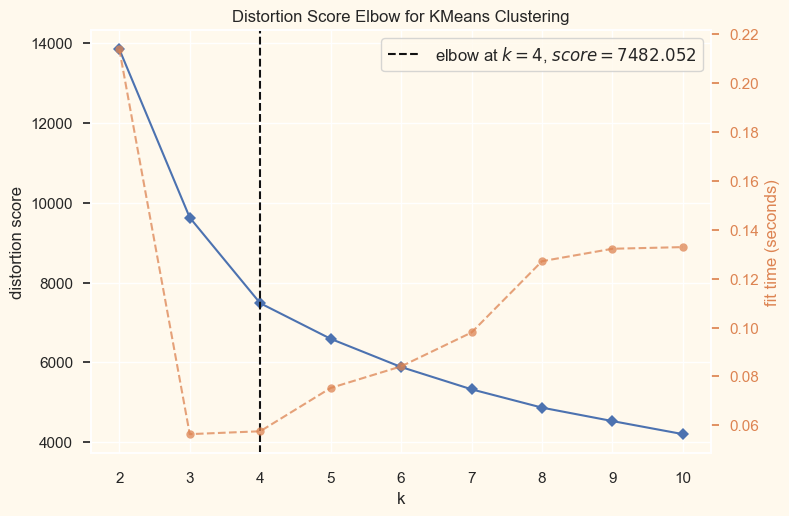

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [20]:
"""The above cell indicates that four will be an optimal number of clusters for this data. Next,
we will be fitting the Agglomerative Clustering Model to get the final clusters."""
#Initiating the Agglomerative Clustering model 
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

### ploting of the cluster formed

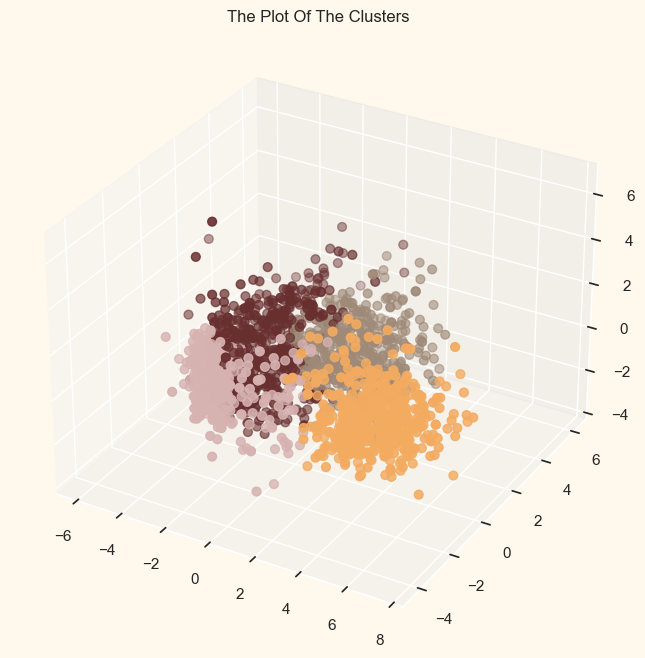

In [21]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

### Model Evaluation

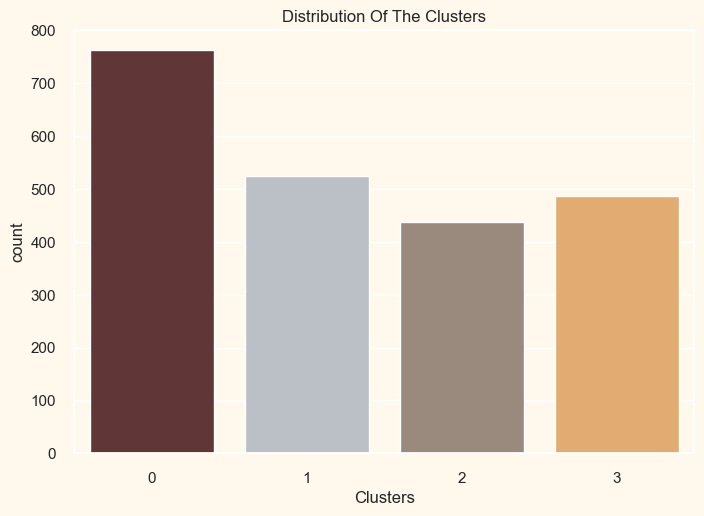

In [22]:
#let's have a look at the group distribution of clustring
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

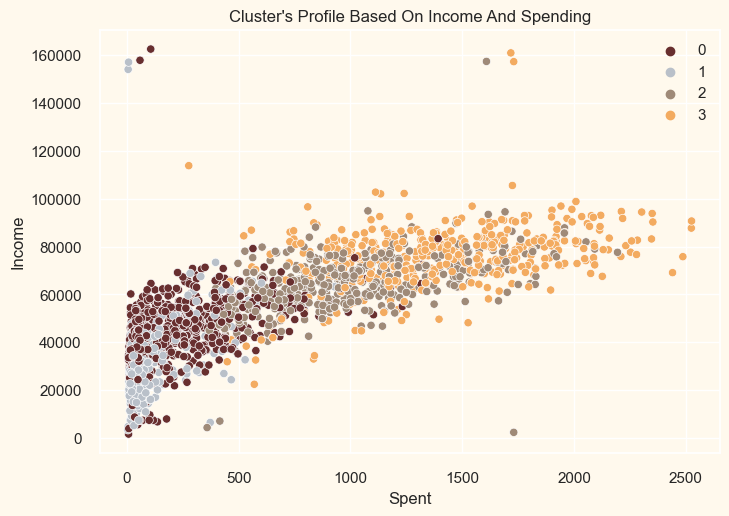

In [23]:
pl = sns.scatterplot(data = df,x=df["Spent"], y=df["Income"],hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

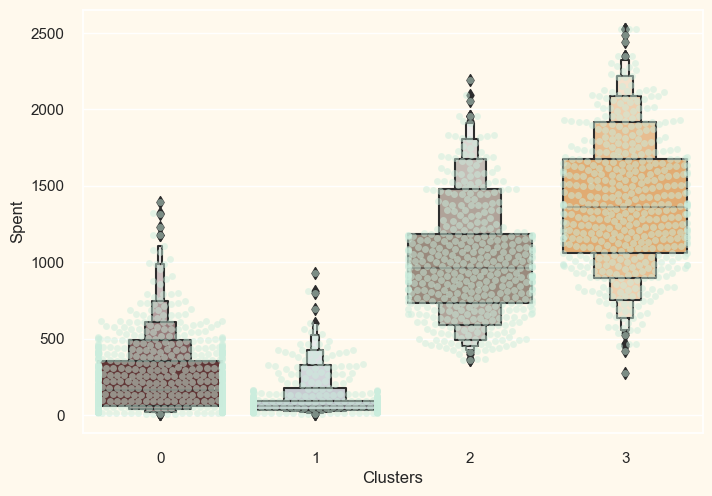

In [24]:
plt.figure()
pl=sns.swarmplot(x=df["Clusters"], y=df["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=df["Clusters"], y=df["Spent"], palette=pal)
plt.show()

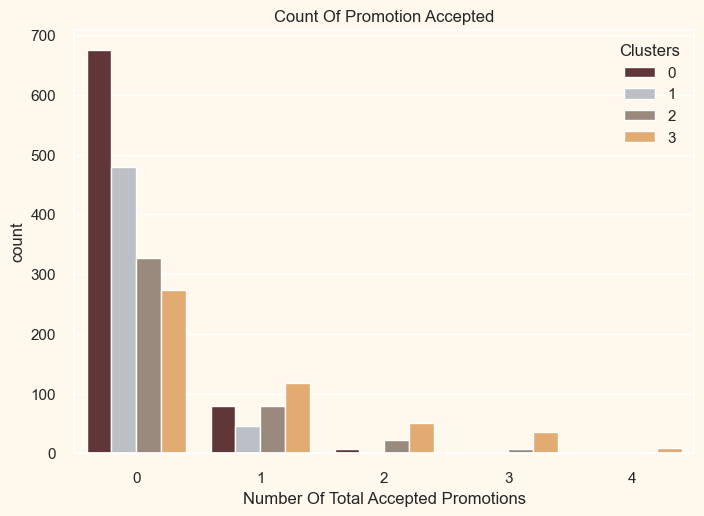

In [25]:
#Creating a feature to get a sum of accepted promotions 
df["Total_Promos"] = df["AcceptedCmp1"]+ df["AcceptedCmp2"]+ df["AcceptedCmp3"]+ df["AcceptedCmp4"]+ df["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=df["Total_Promos"],hue=df["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

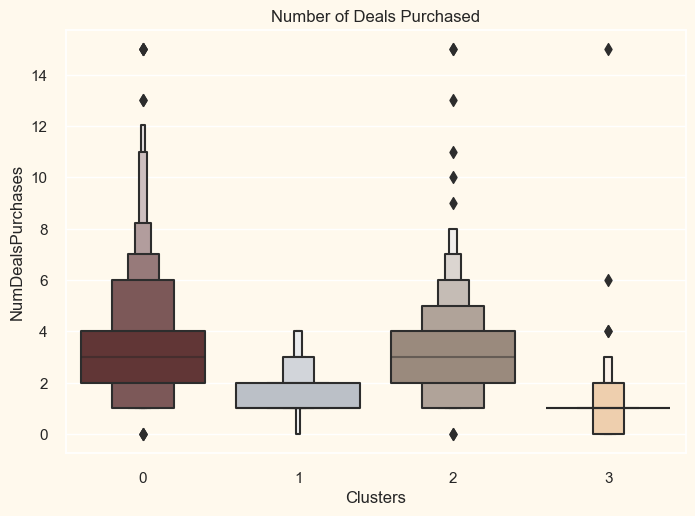

In [26]:
#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=df["NumDealsPurchases"],x=df["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

### scores

In [29]:
score = metrics.silhouette_score(PCA_ds, AC.labels_ , random_state=42)
print("Silhouette score",score)
DB=metrics.davies_bouldin_score(PCA_ds, AC.labels_)
print("davies bouldin score",DB)

Silhouette score 0.3618233538169793
davies bouldin score 1.0483113312223376
